<a href="https://colab.research.google.com/github/AditiSSNR/Maize-Disease/blob/main/Maize_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STEP 1:** Install Dependencies and Import necessary packages

In [1]:
# Install required dependencies
!pip install -U flwr ray tensorflow keras scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 

In [2]:
# Import packages
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

from tqdm import tqdm
import os
import random

from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import flwr as fl
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

**STEP 2:** Data Preprocessing

In [3]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path to train and test dataset
train_dir = "/content/drive/MyDrive/Corn_disease/training_set"
test_dir = "/content/drive/MyDrive/Corn_disease/test_set"

In [5]:
# Collect the file paths and corresponding labels for training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+'/'+label):
        train_paths.append(train_dir+'/'+label+'/'+image)
        train_labels.append(label)

# Shuffle the paths and labels in to ensure the training data isn't biased by directory ordering
train_paths, train_labels = shuffle(train_paths, train_labels)

In [6]:
# Collect the file paths and corresponding labels for test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+'/'+label):
        test_paths.append(test_dir+'/'+label+'/'+image)
        test_labels.append(label)

# Shuffle the paths and labels in to ensure the test data isn't biased by directory ordering
test_paths, test_labels = shuffle(test_paths, test_labels)

Train: 3082 Test: 770


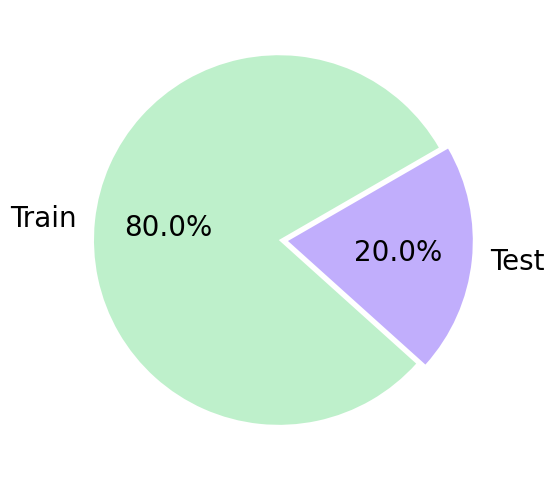

In [7]:
# Display percentage training and testing data
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
print('Train:', len(train_labels), 'Test:', len(test_labels))
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [8]:
# Apply image augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

In [9]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

In [10]:
# Perform label encoding and decoding

unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

# Perform batch-wise image loading
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

**STEP 3:** Build EfficientNetV2 Base Model

In [15]:
# EfficientNetV2B0 base
base_model = EfficientNetV2B0(
    include_top=False,
    input_shape=(128,128,3),
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # freeze base initially

model = keras.Sequential([
    base_model,
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 15
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 1.3828 - sparse_categorical_accuracy: 0.3306
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 0.9483 - sparse_categorical_accuracy: 0.6753
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 0.7016 - sparse_categorical_accuracy: 0.7837
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - loss: 0.5522 - sparse_categorical_accuracy: 0.8420
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - loss: 0.4577 - sparse_categorical_accuracy: 0.8500
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 0.3847 - sparse_categorical_accuracy: 0.8766
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - loss: 0.3275 - sparse_categorical_accuracy: 0.8935
Epoch 8/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - loss: 0.2844 - sparse_categorical_accuracy: 0.9140
Epoch 9/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 0.2481 - sparse_categorical_accuracy: 0.9188
Epoch 10/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 224s 

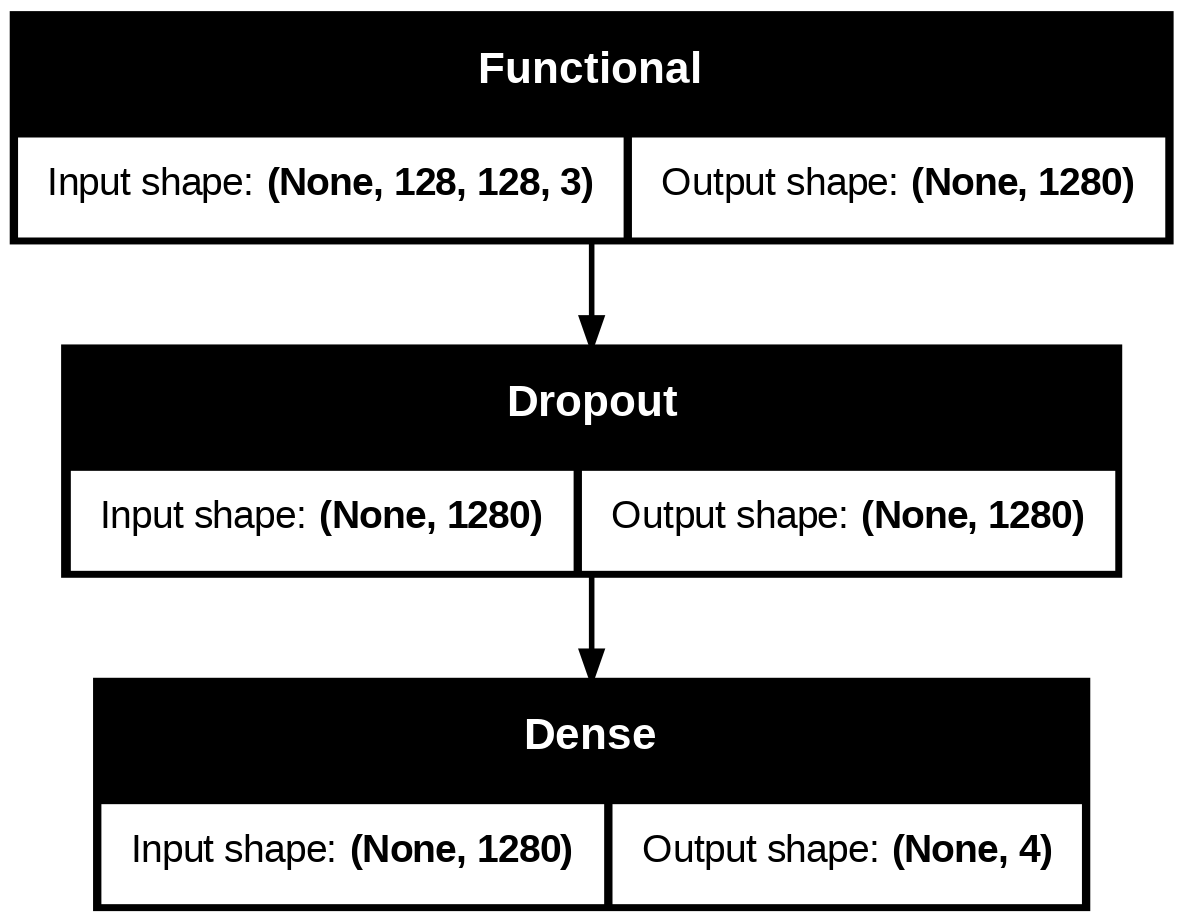

In [20]:
 keras.utils.plot_model(model, show_shapes=True)

**STEP 4:** Federated Learning Based Transfer Learning enabled EfficientNetV2 Model

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 5
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 20
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9653
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9787
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9821
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9885
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9729
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9614
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.1275 - sparse_categorical_accuracy: 0.9605
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9670
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0984 - sparse_categorical_accuracy: 0.9798
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.1417 - sparse_categor

  0%|          | 0/38 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  3%|▎         | 1/38 [00:05<03:18,  5.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


  5%|▌         | 2/38 [00:06<01:38,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  8%|▊         | 3/38 [00:07<01:06,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 11%|█         | 4/38 [00:07<00:46,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 13%|█▎        | 5/38 [00:08<00:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 16%|█▌        | 6/38 [00:08<00:27,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 18%|█▊        | 7/38 [00:09<00:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 21%|██        | 8/38 [00:09<00:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 24%|██▎       | 9/38 [00:10<00:17,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 26%|██▋       | 10/38 [00:10<00:16,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 29%|██▉       | 11/38 [00:11<00:14,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 32%|███▏      | 12/38 [00:11<00:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 34%|███▍      | 13/38 [00:12<00:13,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 37%|███▋      | 14/38 [00:13<00:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 39%|███▉      | 15/38 [00:13<00:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 42%|████▏     | 16/38 [00:14<00:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 45%|████▍     | 17/38 [00:14<00:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 47%|████▋     | 18/38 [00:15<00:11,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 50%|█████     | 19/38 [00:15<00:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 53%|█████▎    | 20/38 [00:16<00:09,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 55%|█████▌    | 21/38 [00:16<00:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 58%|█████▊    | 22/38 [00:17<00:09,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 61%|██████    | 23/38 [00:18<00:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 63%|██████▎   | 24/38 [00:19<00:10,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 66%|██████▌   | 25/38 [00:19<00:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 68%|██████▊   | 26/38 [00:20<00:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 71%|███████   | 27/38 [00:21<00:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 74%|███████▎  | 28/38 [00:21<00:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 76%|███████▋  | 29/38 [00:22<00:05,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 79%|███████▉  | 30/38 [00:22<00:04,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 82%|████████▏ | 31/38 [00:23<00:03,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 84%|████████▍ | 32/38 [00:23<00:03,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 87%|████████▋ | 33/38 [00:24<00:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 89%|████████▉ | 34/38 [00:24<00:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 92%|█████████▏| 35/38 [00:25<00:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 95%|█████████▍| 36/38 [00:25<00:01,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 97%|█████████▋| 37/38 [00:26<00:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


100%|██████████| 38/38 [00:26<00:00,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


39it [00:32,  1.21it/s]


**STEP 5:** Model Evaluation

In [17]:
# Generate classification report on evaluation metrics
print(classification_report(y_true, y_pred))

                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.86      0.83       103
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
               Corn_(maize)___Northern_Leaf_Blight       0.93      0.89      0.91       197
                            Corn_(maize)___healthy       0.99      1.00      1.00       232

                                          accuracy                           0.95       770
                                         macro avg       0.93      0.94      0.93       770
                                      weighted avg       0.95      0.95      0.95       770



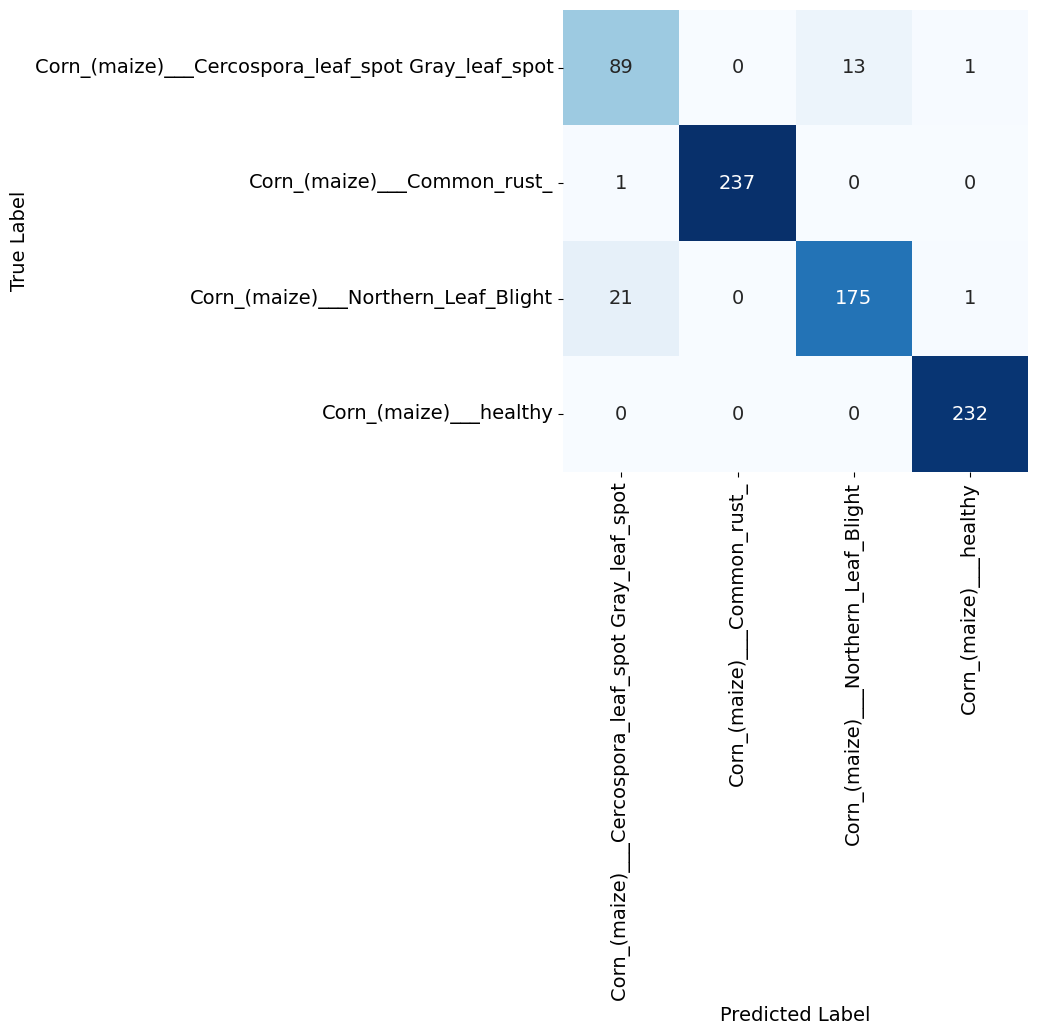

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 14

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()